# Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Load Data](#2.-Load-Data)
- [3. LeNet-5](#3.-LeNet-5)
  - [3.1. LeNet-5 Original](#3.1.-LeNet-5-Original)
  - [3.2. LeNet-5 Modern](#3.2.-LeNet-5-Modern)
- [4. AlexNet](#4.-AlexNet)
- [5. VGG Net](#5.-VGG-Net)
- [6. Conclusion](#6.-Conclusion)

# 1. Introduction

This notebook is part of Hao Chen's deep learning project for LPI Artificial intelligence (2023-2023). This project builds a fully connected neural network and a convolutional neural network for FashionMNIST dataset. This notebook contains the code for CNN models. 

This notebook implemented CNN models inspired by these three classic architectures, the LeNet, the AlexNet, and the VGG net. My knowlege on CNNs and these architectures comes from Andrew Ng's [YouTube course on convolutional neural networks](https://www.youtube.com/watch?v=ArPaAX_PhIs&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF).

**LeNet-5**
- Original version
    - I replicated the original LeNet-5 by using Tanh activation, average pooling, and softmax activation at the output layer.
    - It achieved around ~0.88 accuracy on test set after 25 training epochs.
- Modern improved version
    - I improvode the LeNet-5 model by using more modern conventions, e.g., ReLU activation, max pooling, and softmax activation at the output layer.
    - It achieved similar around ~0.88 accuracy on test set after 25 training epochs.

**AlexNet**
- I built a CNN with simplified architecture from AlexNet, i.e., by using strides and max pooling layers. 
- I trained the network on MPS (the Macbook equivalent of cuda) to speed up training.
- The model achieved ~0.88-0.90 accuracy on test set after 25 training epochs.

**VGG Net**
- I also build a CNN with arhitecture inspired by VGG.
- The parameters and arhictecture of this model come from [Keras tutorial](https://pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/#:~:text=The%20Fashion%20MNIST%20dataset,-Figure%201%3A%20The&text=It's%20far%20too%20easy%20for,to%20achieve%2099%25%2B%20accuracy).
- The model achieved ~0.92-0.93 accuracy on test set after 25 training epochs on MPS.

## 1.1. Check environment

In [14]:
import torch
from platform import python_version

# Report the versions of overall environment 
print(f'Python version: {python_version()}')
print(f'PyTorch version: {torch.__version__}')

# Report the availability or GPU and MPS training 
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()

print(f'Cuda Availablility: {cuda_available}')
print(f'Metal Performance Shaders (MPS) Availablility: {mps_available}')

Python version: 3.11.5
PyTorch version: 2.1.2
Cuda Availablility: False
Metal Performance Shaders (MPS) Availablility: True


# 2. Load Data

## 2.1. Load downloaded data using customised function

In [15]:
import numpy as np
from utils.dataset import import_data

# Set data path
train_label_path = './data/FashionMNIST/raw/train-labels-idx1-ubyte'
train_images_path = './data/FashionMNIST/raw/train-images-idx3-ubyte'
test_label_path = './data/FashionMNIST/raw/t10k-labels-idx1-ubyte'
test_images_path = './data/FashionMNIST/raw/t10k-images-idx3-ubyte'

# import data
images = import_data(train_images_path, images=True, train=True, flatten=False)
labels = import_data(train_label_path, images=False, train=True)
test_images = import_data(test_images_path, images=True, train=False, flatten=False)
test_labels = import_data(test_label_path, images=False, train=False)

Imported file: ./data/FashionMNIST/raw/train-images-idx3-ubyte
Data type: images; Data shape: (60000, 28, 28)
Imported file: ./data/FashionMNIST/raw/train-labels-idx1-ubyte
Data type: labels; Data shape: (60000,)
Imported file: ./data/FashionMNIST/raw/t10k-images-idx3-ubyte
Data type: images; Data shape: (10000, 28, 28)
Imported file: ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte
Data type: labels; Data shape: (10000,)


## 2.2. Stratified Data Split (50k:10k:10k)

The original data has 60k samples in training dataset and 10k samples in test dataset. The split was stratified based on the class of target labels. 

Here I split the original training dataset into 50k samples for training and 10k samples for validation, stratified based on the class of target labels. 

In [16]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=1/6, random_state=42, stratify=labels
)

In [17]:
print(f'The shape of train image data: {train_images.shape}')
print(f'The shape of train label data: {train_labels.shape}')
print(f'The shape of validation image data: {val_images.shape}')
print(f'The shape of validation label data: {val_labels.shape}')
print(f'The shape of validation image data: {test_images.shape}')
print(f'The shape of test label data: {test_labels.shape}')

The shape of train image data: (50000, 28, 28)
The shape of train label data: (50000,)
The shape of validation image data: (10000, 28, 28)
The shape of validation label data: (10000,)
The shape of validation image data: (10000, 28, 28)
The shape of test label data: (10000,)


## 2.3. Sanity check

### 2.3.1. Check class distribution

Check number of classes in each dataset

In [18]:
import pandas as pd

# Store the names of target labels into a list
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Count the number of labels in each dataset
label_counts = {}
label_counts['train'] = pd.Series(train_labels).sort_values().value_counts()
label_counts['val'] = pd.Series(val_labels).sort_values().value_counts()
label_counts['test']  = pd.Series(test_labels).sort_values().value_counts()

# Present the distribution using pandas dataframe
label_counts_df = pd.DataFrame(label_counts)
label_counts_df.index = classes

label_counts_df

,train,val,test
T-shirt/top,5000,1000,1000
Trouser,5000,1000,1000
Pullover,5000,1000,1000
Dress,5000,1000,1000
Coat,5000,1000,1000
Sandal,5000,1000,1000
Shirt,5000,1000,1000
Sneaker,5000,1000,1000
Bag,5000,1000,1000
Ankle Boot,5000,1000,1000


### 2.3.2 Check images

Randomly select one image from each class, display them.

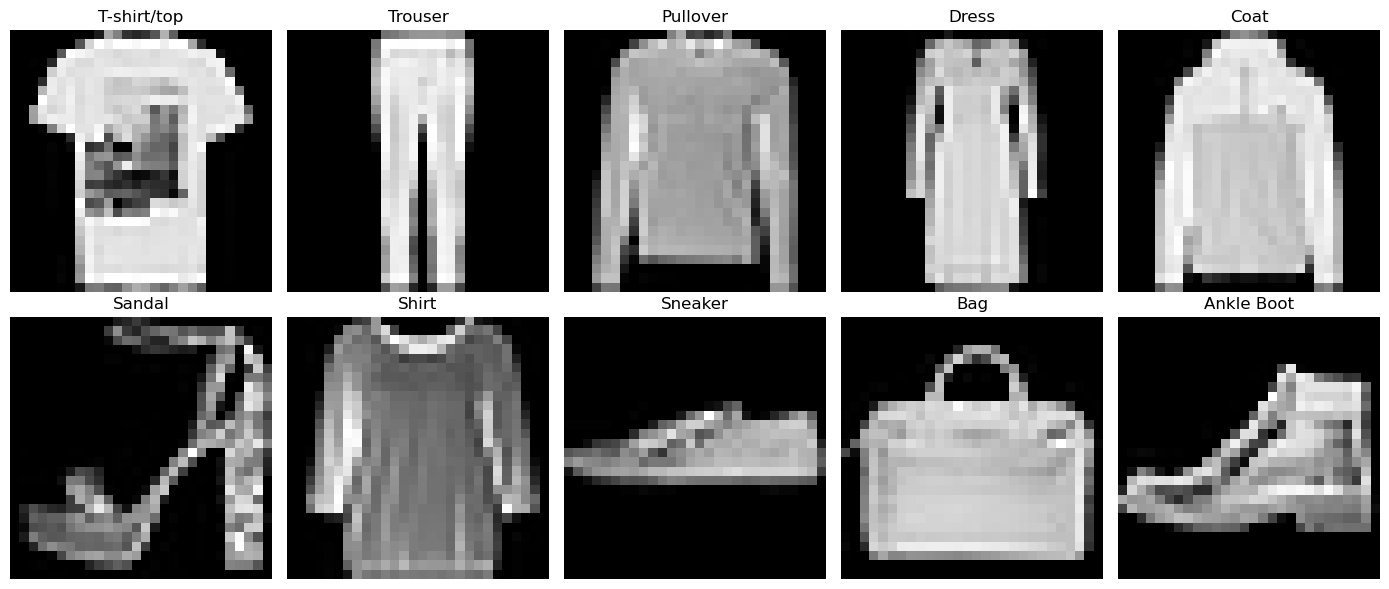

In [19]:
import matplotlib.pyplot as plt

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Set up a figure with 10 axes
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i in range(len(classes)):
    # Find indices of all images belonging to class i
    class_indices = np.where(train_labels == i)[0]
    # Randomly sample one index
    image_idx = np.random.choice(class_indices)
    # Retrieve and display the randomly selected image
    # Reshape the flattened image data back to 28*28 pixels
    image_data = train_images[image_idx].reshape(28, 28)
    # Set cmaps as 'gray', as picture is in grayscale
    axes[i // 5, i % 5].imshow(image_data, cmap='gray')
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(classes[i])

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

## 2.4. Preload Dataset using Custom Dataset

In [20]:
from utils.dataset import FashionData

In [21]:
train_data = FashionData(train_images, train_labels, unsqueeze=True)
val_data = FashionData(val_images, val_labels, unsqueeze=True)
test_data = FashionData(test_images, test_labels, unsqueeze=True)

In [22]:
val_data.images[0].shape

torch.Size([28, 28])

## 2.5 Data Loading

In [23]:
# Loading
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# 3. LeNet-5

The LeNet is one of the earliest convolutional neural network, designed by LeCun et al. (1998) for the MNIST dataset. Below is the structure of the original LeNet. 

For the original version LeNet, I'll replicate this model completely (i.e., filter size, stride, and activation function). I'll adjust the number of parameters a little bit, because the dimension of FashionMNIST data is 28 X 28 instead of 32 X 32.

For the modern improved version, I'll change the activation function from tanh to ReLU, use max pooling instead of average pooling, and discard the Softmax activation function at the output layer due to its vanishing gradient issue.

![image](./pictures/LeNet_architecture_table.png)

## 3.1. LeNet-5 Original

In [24]:
from torch import nn
import time
import torchmetrics
from utils.model_train_test import train_validate_iteration

In [25]:
# Define the LeNet architecture
class LeNetLegacy(nn.Module):
    def __init__(self):
        super(LeNetLegacy, self).__init__()
        self.conv_layer1 = nn.Sequential(
            # First conv layer: 
            # in_channels=1: 1 input channel, given it's gray scale image
            # out_channels=6: 6 output features
            # kernel_size=5: 5 by 5 filter
            # 28 X 28 X 1 -> 24 X 24 X 6
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=6),
            # Activation function
            nn.Tanh(),
            # Pooling layer: Average pooling
            # kernel_size=2: 2 by 2 filter
            # stride=2: skip one pixel, (its default value is the kernel size)
            # 24 X 24 X 6-> 12 X 12 X 6
            nn.AvgPool2d(kernel_size=2, stride=2))

        self.conv_layer2 = nn.Sequential(
            # Second conv layer: 
            # in_channels=6: 6 input channels (i.e., features)
            # out_channels=16: 16 output features
            # kernel_size=5: 5 by 5 filter
            # 12 X 12 X 6 -> 8 X 8 X 16
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=16),
            # Activation function
            nn.Tanh(),
            # Pooling layer: average pooling, the same to previous
            # 8 X 8 X 16 -> 4 x 4 X 16
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            # Flatten the image for fully connected layers
            nn.Flatten(),
            # FC layer1
            nn.Linear(4*4*16, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            # FC layer2
            nn.Tanh(),
            nn.Linear(84, 10)
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_layers(x)
        x = self.softmax(x)
        return x

In [26]:
# training
device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = LeNetLegacy().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=25,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 25
-------------------------------
Training epoch: 1


average training loss: 1.7078103705135452
train set score: 0.7696599960327148
average validation loss: 1.6452025235838192
validation set score: 0.8190000057220459
-------------------------------
Training epoch: 2
average training loss: 1.6273199188739746
train set score: 0.8370800018310547
average validation loss: 1.6090265474501688
validation set score: 0.8540999889373779
-------------------------------
Training epoch: 3
average training loss: 1.6102968179966177
train set score: 0.8522800207138062
average validation loss: 1.5996085025702313
validation set score: 0.8647000193595886
-------------------------------
Training epoch: 4
average training loss: 1.599603370632357
train set score: 0.8627399802207947
average validation loss: 1.5932074071495397
validation set score: 0.8705000281333923
-------------------------------
Training epoch: 5
average training loss: 1.5921997620016717
train set score: 0.8701000213623047
average validation loss: 1.5912275132100293
validation set score: 0.869

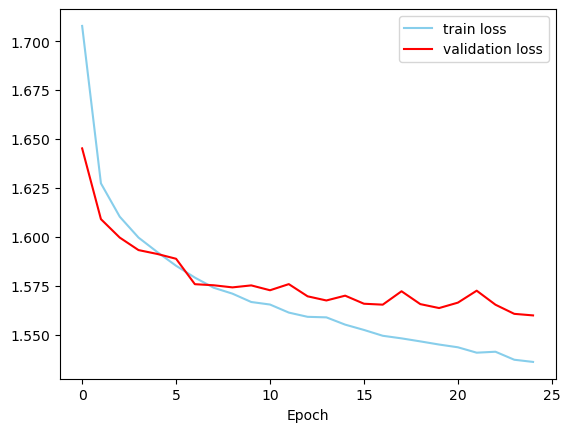

In [27]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

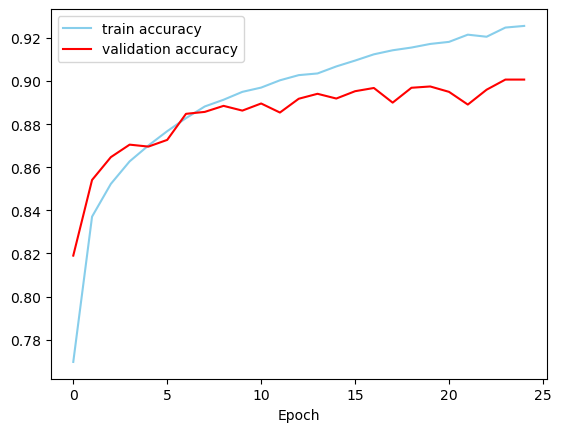

In [28]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Measure performance on test data

In [29]:
from utils.model_train_test import metrics_across_classes

In [30]:
metrics_across_classes(test_dataloader, model, device=device)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.848943   0.843  0.845961     1000
1      Trouser   0.984833   0.974  0.979387     1000
2     Pullover   0.830721   0.795  0.812468     1000
3        Dress   0.847846   0.925  0.884744     1000
4         Coat   0.757412   0.843  0.797918     1000
5       Sandal   0.976697   0.964  0.970307     1000
6        Shirt   0.747045   0.632  0.684724     1000
7      Sneaker   0.947948   0.947  0.947474     1000
8          Bag   0.963111   0.966  0.964553     1000
9   Ankle Boot   0.948141   0.969  0.958457     1000
--------------------------------------------------
Overall accuracy: 0.886
Macro average precision: 0.885, Recall: 0.886, F1: 0.885
Weighted average precision: 0.885, Recall: 0.886, F1: 0.885


## 3.2. LeNet-5 Modern

In [31]:
# Define the LeNet architecture
class LeNetModern(nn.Module):
    def __init__(self):
        super(LeNetModern, self).__init__()
        self.conv_layer1 = nn.Sequential(
            # First conv layer: 
            # in_channels=1: 1 input channel, given it's gray scale image
            # out_channels=6: 6 output features
            # kernel_size=5: 5 by 5 filter
            # 28 X 28 X 1 -> 24 X 24 X 6
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=6),
            # Activation function
            nn.ReLU(),
            # Pooling layer: Max pooling
            # kernel_size=2: 2 by 2 filter
            # stride=2: skip one pixel, (its default value is the kernel size)
            # 24 X 24 X 6-> 12 X 12 X 6
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_layer2 = nn.Sequential(
            # Second conv layer: 
            # in_channels=6: 6 input channels (i.e., features)
            # out_channels=16: 16 output features
            # kernel_size=5: 5 by 5 filter
            # 12 X 12 X 6 -> 8 X 8 X 16
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=16),
            # Activation function
            nn.ReLU(),
            # Pooling layer: average pooling, the same to previous
            # 8 X 8 X 16 -> 4 x 4 X 16
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            # Flatten the image for fully connected layers
            nn.Flatten(),
            # FC layer1
            nn.Linear(4*4*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # FC layer2
            nn.ReLU(),
            nn.Linear(84, 10)
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_layers(x)
        x = self.softmax(x)

        return x

In [32]:
# training
device ='cpu'
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = LeNetModern().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=25,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 25
-------------------------------
Training epoch: 1


average training loss: 1.6891312529059017
train set score: 0.7799999713897705
average validation loss: 1.62006762832593
validation set score: 0.8434000015258789
-------------------------------
Training epoch: 2
average training loss: 1.6171076136171971
train set score: 0.845300018787384
average validation loss: 1.6113218418352164
validation set score: 0.8521000146865845
-------------------------------
Training epoch: 3
average training loss: 1.6037272021288762
train set score: 0.8576599955558777
average validation loss: 1.5954032999694727
validation set score: 0.8655999898910522
-------------------------------
Training epoch: 4
average training loss: 1.595654244922921
train set score: 0.8656399846076965
average validation loss: 1.5900879528871767
validation set score: 0.871399998664856
-------------------------------
Training epoch: 5
average training loss: 1.5900470844620025
train set score: 0.8711000084877014
average validation loss: 1.5865089802225685
validation set score: 0.8756999

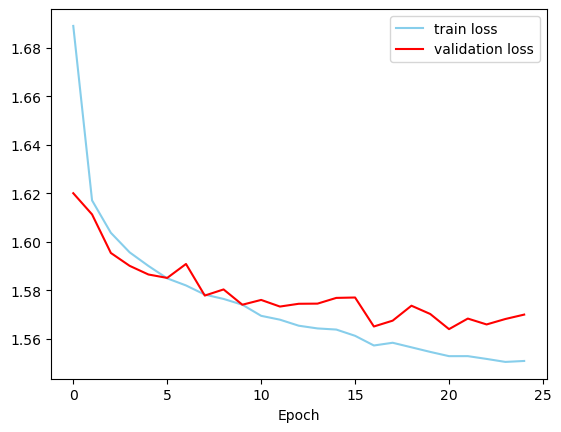

In [33]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

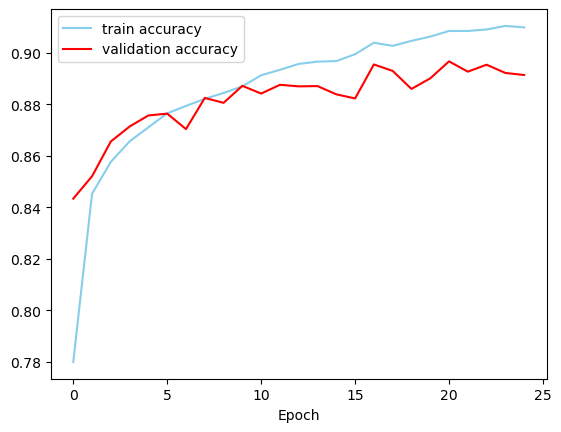

In [34]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Measure performance on test data

In [35]:
from utils.model_train_test import metrics_across_classes

In [36]:
metrics_across_classes(test_dataloader, model, device, classes)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.871041   0.770  0.817410     1000
1      Trouser   0.982794   0.971  0.976861     1000
2     Pullover   0.895906   0.766  0.825876     1000
3        Dress   0.879921   0.894  0.886905     1000
4         Coat   0.823590   0.803  0.813165     1000
5       Sandal   0.987395   0.940  0.963115     1000
6        Shirt   0.620771   0.789  0.694848     1000
7      Sneaker   0.920304   0.970  0.944499     1000
8          Bag   0.953786   0.970  0.961824     1000
9   Ankle Boot   0.961538   0.950  0.955734     1000
--------------------------------------------------
Overall accuracy: 0.882
Macro average precision: 0.890, Recall: 0.882, F1: 0.884
Weighted average precision: 0.890, Recall: 0.882, F1: 0.884


# 4. AlexNet

The AlexNet was developed by Sutskever and Hinton (2012), with its architecture shown below. Compared with LeNet, AlexNet first uses big strides (s=4), large filters (11X11), and max pooling to reduce the image dimensions and expand channels (from 3 to 96). Then, it uses smaller stride (s=2), small filter (5X5), and max pooling again to reduce dimensions and expand channels. It finishes by same padding convolutional layers with 3X3 filter, before feeding into the fully connected layers.

This architecture works well on big images (e.g., 224 X 224 pixels). However, the image size of FashionMNIST was only 28 X 28 pixels, using strides and max pooling together will reduce the image size dramatically. 

Nonetheless, I built and tested a small CNN inspired by the AlexNet. The simpleAlexNet below has two convolutional layers with stride and two pooling layers. Because the image size after these layers were too small (i.e., 2X2), I did not apply the last sequence of 3X3 convolutional layers with same padding in the AlexNet.

<img src="./pictures/LeNet_AlexNet_comparison.svg.png" width="500" />

<img src="./pictures/AlexNet.webp" width="600" />

In [37]:
# Define the LeNet architecture
class SimpleAlexNet(nn.Module):
    def __init__(self):
        super(SimpleAlexNet, self).__init__()

        # First conv layer sequence: 28X28X1 -> 14X14X32 -> 7X7X32
        self.conv_layer1 = nn.Sequential(
            # 28X28X1 -> 10X10X32
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            # 14X14X32 -> 7X7X32
            nn.MaxPool2d(kernel_size=2, stride=2)           
            )
        
        self.conv_layer2 = nn.Sequential(
            # 7X7X32 -> 4X4X64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            # 4X4X64 -> 2X2X64
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # FC layer sequence
        self.fc_sequence = nn.Sequential(
            nn.Flatten(), # Flatten the image for fully connected layers
            nn.Linear(2*2*64, 512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 216),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=216),
            nn.Linear(216, 84),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=84),
            nn.Linear(84, 10)
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_sequence(x)
        x = self.softmax(x)
        
        return x

In [38]:
# training
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
device ='mps'
torch.mps.empty_cache()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = SimpleAlexNet().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=25,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 25
-------------------------------
Training epoch: 1


average training loss: 1.6534707346535704
train set score: 0.8174600005149841
average validation loss: 1.6144334738421593
validation set score: 0.8481000065803528
-------------------------------
Training epoch: 2
average training loss: 1.6053137948445957
train set score: 0.8566799759864807
average validation loss: 1.5980825614018046
validation set score: 0.8637999892234802
-------------------------------
Training epoch: 3
average training loss: 1.5919594132077053
train set score: 0.8690000176429749
average validation loss: 1.5883979584760726
validation set score: 0.8715999722480774
-------------------------------
Training epoch: 4
average training loss: 1.5855999945679589
train set score: 0.875819981098175
average validation loss: 1.578665776617208
validation set score: 0.8830999732017517
-------------------------------
Training epoch: 5
average training loss: 1.5789271917794367
train set score: 0.8820800185203552
average validation loss: 1.575727733077517
validation set score: 0.88550

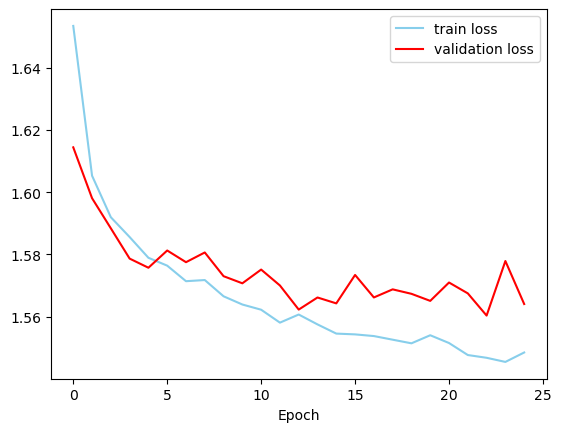

In [39]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

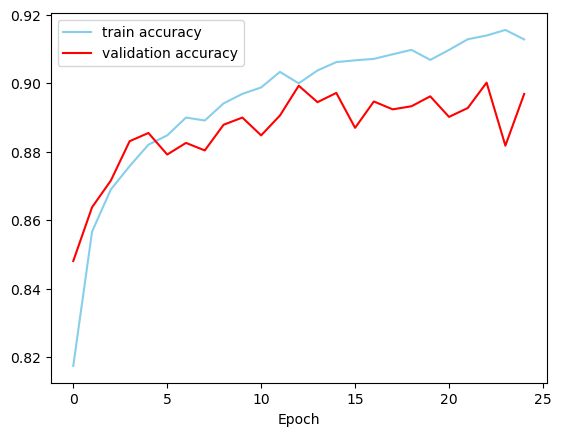

In [40]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Measure performance on test data

In [41]:
from utils.model_train_test import metrics_across_classes

In [42]:
metrics_across_classes(test_dataloader, model, device, classes)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.816403   0.876  0.845152     1000
1      Trouser   0.985743   0.968  0.976791     1000
2     Pullover   0.818182   0.819  0.818591     1000
3        Dress   0.885458   0.889  0.887226     1000
4         Coat   0.741056   0.870  0.800368     1000
5       Sandal   0.977528   0.957  0.967155     1000
6        Shirt   0.763089   0.583  0.660998     1000
7      Sneaker   0.916510   0.977  0.945789     1000
8          Bag   0.968907   0.966  0.967451     1000
9   Ankle Boot   0.978125   0.939  0.958163     1000
--------------------------------------------------
Overall accuracy: 0.884
Macro average precision: 0.885, Recall: 0.884, F1: 0.883
Weighted average precision: 0.885, Recall: 0.884, F1: 0.883


# 5. VGG Net

The VGG network is developed by Simonyan and Zisserman (2014) based on the AlexNet, with its architecture shown below. The VGG network is often preferred over AlexNet due to its simplicity.

The VGG network entails repeated sequences of convolutional layers and a max pooling layer. Each sequence has two convolutional layers with 3X3 filters and same padding to extract features and then 1 max pooling layer with 2X2 filters and 2 strides to half image size. By repeating this sequence, it builds a deep network.

Below, I build a simple VGG network using parameters of this [Keras tutorial](https://pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/#:~:text=The%20Fashion%20MNIST%20dataset,-Figure%201%3A%20The&text=It's%20far%20too%20easy%20for,to%20achieve%2099%25%2B%20accuracy). I translate most of its code from Keras to Pytorch, except the optimizer. The original optimizer has a learning rate that decays as the number of training epochs increases as well as a momentum factor of 0.9. To simplify the code, I used the Adam optimizer.

<img src="./pictures/vgg_architecture.png" width="700" />

<img src="./pictures/vgg_architecture_2.jpeg" width="650" />

In [43]:
# Define the LeNet architecture
class SimpleVGGNet(nn.Module):
    def __init__(self):
        super(SimpleVGGNet, self).__init__()

        # First conv layer sequence: 28X28X1 -> 14X14X32
        self.conv_sequence1 = nn.Sequential(
            # First conv layer in sequence 1
            # Same padding, extract 32 features
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Activation function
            nn.ReLU(),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=32),
            # First conv layer in sequence 1
            # Same padding, 32 features
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Activation function
            nn.ReLU(),
            # Apply batch normalization
            nn.BatchNorm2d(num_features=32),
            # Max pooling, halfing dimensions
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Randomly zeroes 25% of the elements of the input, to prevent overfitting
            nn.Dropout(0.25)
            )
        
        # First conv layer sequence: 14X14X32 -> 7X7X64
        self.conv_sequence2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
            )
        
        # FC later sequence
        self.fc_sequence = nn.Sequential(
            nn.Flatten(), # Flatten the image for fully connected layers
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_sequence1(x)
        x = self.conv_sequence2(x)
        x = self.fc_sequence(x)
        return x

In [44]:
# training
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
device ='mps'
torch.mps.empty_cache()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = SimpleVGGNet().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

summary = train_validate_iteration(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=25,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Total number of epochs: 25
-------------------------------
Training epoch: 1


average training loss: 0.6005246995012169
train set score: 0.7929199934005737
average validation loss: 0.3834218752042503
validation set score: 0.864799976348877
-------------------------------
Training epoch: 2
average training loss: 0.3823827296647879
train set score: 0.8629999756813049
average validation loss: 0.2709100159585096
validation set score: 0.9031999707221985
-------------------------------
Training epoch: 3
average training loss: 0.3236197458718286
train set score: 0.8833799958229065
average validation loss: 0.28299161639942483
validation set score: 0.9023000001907349
-------------------------------
Training epoch: 4
average training loss: 0.2997574055915141
train set score: 0.8922600150108337
average validation loss: 0.2884467853482362
validation set score: 0.8938000202178955
-------------------------------
Training epoch: 5
average training loss: 0.29520800426754806
train set score: 0.8941799998283386
average validation loss: 0.24364700775807072
validation set score: 0.

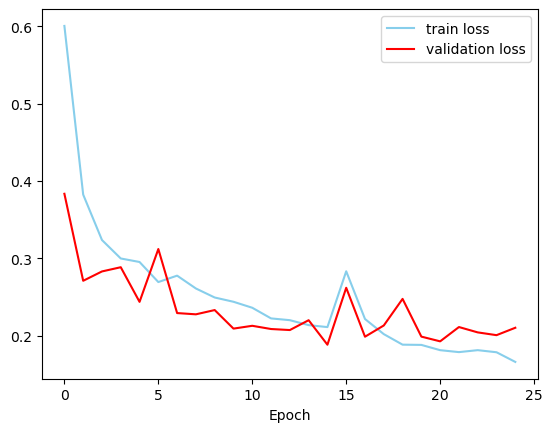

In [45]:
plt.plot(summary['train_loss'], color='skyblue', label='train loss')
plt.plot(summary['val_loss'], color='red', label='validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

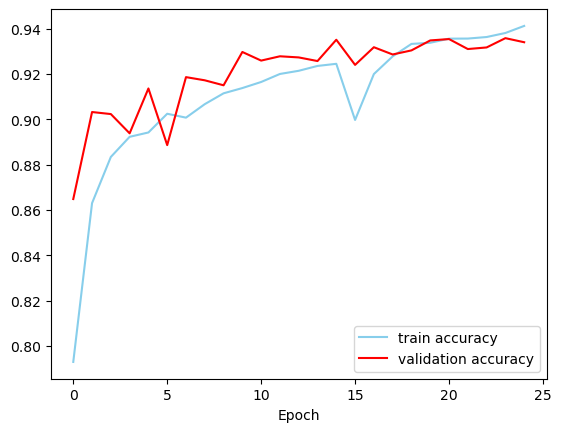

In [46]:
plt.plot(summary['train_score'], color='skyblue', label='train accuracy')
plt.plot(summary['val_score'], color='red', label='validation accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Measure performance on test data

In [47]:
metrics_across_classes(test_dataloader, model, device=device)

         class  precision  recall  f1-score  support
0  T-shirt/top   0.830341   0.925  0.875118     1000
1      Trouser   0.997972   0.984  0.990937     1000
2     Pullover   0.872401   0.923  0.896987     1000
3        Dress   0.911260   0.955  0.932617     1000
4         Coat   0.940265   0.850  0.892857     1000
5       Sandal   0.987026   0.989  0.988012     1000
6        Shirt   0.835458   0.721  0.774020     1000
7      Sneaker   0.952794   0.989  0.970559     1000
8          Bag   0.972630   0.995  0.983688     1000
9   Ankle Boot   0.988589   0.953  0.970468     1000
--------------------------------------------------
Overall accuracy: 0.928
Macro average precision: 0.929, Recall: 0.928, F1: 0.928
Weighted average precision: 0.929, Recall: 0.928, F1: 0.928


# 6. Conclusion

Among CNNs of three types of architecture, the CNN using VGG architecture achieved the best accuracy after 25 training epochs. If time permits, I'd like to try on-the-fly data augmentation and early stopping in these models.

# References

**LeNet**
- LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324. Available from https://hal.science/hal-03926082/document
- https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
- https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
- https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/

**AlexNet**
- Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.

**VGG Network**
- Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556. Available from: https://arxiv.org/pdf/1312.6034.pdf
- https://blog.paperspace.com/vgg-from-scratch-pytorch/
- https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/
- https://pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/#:~:text=The%20Fashion%20MNIST%20dataset,-Figure%201%3A%20The&text=It's%20far%20too%20easy%20for,to%20achieve%2099%25%2B%20accuracy